In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from system_ode_fedbatch import generate_data
from machinelearning_control_fedbatch import main, generate_dataset

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

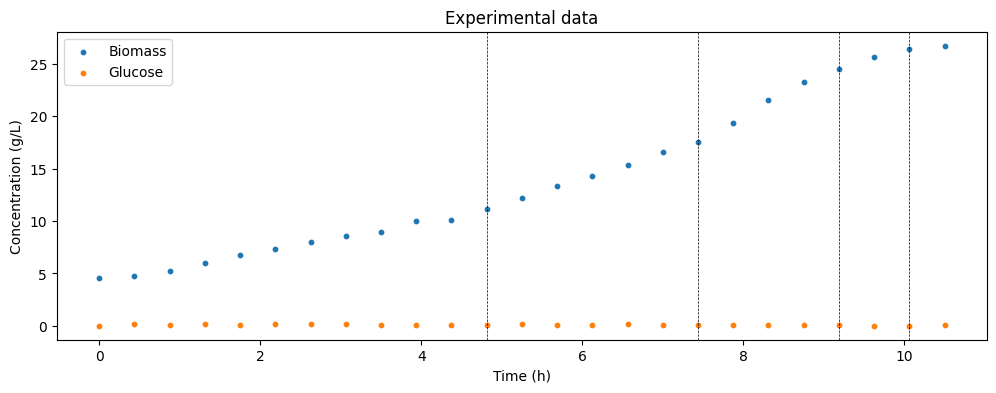

In [3]:
full_df = generate_data()

plt.figure(figsize=(12, 4))
plt.scatter(full_df['RTime'], full_df['Biomass'], s=10, label='Biomass')
plt.scatter(full_df['RTime'], full_df['Glucose'], s=10, label='Glucose')
for i in range(1, len(full_df)):
    if full_df["F"].iloc[i] != full_df["F"].iloc[i - 1]:
        plt.axvline(x=full_df["RTime"].iloc[i], color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.title('Experimental data')
plt.show()

In [4]:
# Get dataset (multiple initial conditions)
in_train, out_train = generate_dataset(full_df)

Dataset shape: (25, 4)


In [6]:
# parameter values
mumax = 0.84     # 1/hour
Ks = 0.2          # g/liter
Yxs = 0.5         # g/g
Sin = 1.43 * 200  # g/liter

# initial conditions
t_start = full_df['RTime'].iloc[0]
t_end = full_df['RTime'].iloc[-1]
V0 = full_df['V'].iloc[0]
S0 = full_df['Glucose'].iloc[0]
X0 = full_df['Biomass'].iloc[0]

print(f'T_start = {t_start}')
print(f'T_end = {t_end}')

T_start = 0.0
T_end = 10.5


In [74]:
from system_ode_fedbatch import get_volume
from machinelearning_control_fedbatch import numpy_to_tensor, grad

mu_max = mumax
K_s = Ks
Y_xs = Yxs

t_col = numpy_to_tensor(np.linspace(t_start, t_end, 10))
X0_col = numpy_to_tensor([X0] * 10)
S0_col = numpy_to_tensor([S0] * 10)
F_col = numpy_to_tensor([0.015] * 10)
V_col = [get_volume(t) for t in t_col]

u_col = torch.cat([t_col, X0_col, S0_col, F_col], dim=1)

preds = net.forward(u_col)

X_pred = preds[:, 0].view(-1, 1)
S_pred = preds[:, 1].view(-1, 1)

dXdt_pred = grad(X_pred, t_col)[0]
dSdt_pred = grad(S_pred, t_col)[0]

mu = mu_max * S_pred / (K_s + S_pred)

error_dXdt = dXdt_pred - mu * X_pred + X_pred * F_col / V_col
error_dSdt = dSdt_pred + mu * X_pred / Y_xs - F_col / V_col * (Sin - S_pred)

error_ode = error_ode + torch.mean(0.5*error_dXdt**2 + 0.5*error_dSdt**2)


TypeError: unsupported operand type(s) for /: 'Tensor' and 'list'

In [9]:
net = main(in_train, out_train, t_start, t_end, Sin, S0, mumax, Ks, Yxs, verbose=10)

Epoch 0, Loss_data: 6.1265, Loss_ode: 0.0000
Epoch 10, Loss_data: 0.0843, Loss_ode: 0.0000
Epoch 20, Loss_data: 0.0294, Loss_ode: 0.0000
Epoch 30, Loss_data: 0.0521, Loss_ode: 0.0000
Epoch 40, Loss_data: 0.0515, Loss_ode: 0.0000
Epoch 50, Loss_data: 0.0386, Loss_ode: 0.0000
Epoch 60, Loss_data: 0.0312, Loss_ode: 0.0000
Epoch 70, Loss_data: 0.0288, Loss_ode: 0.0000
Epoch 80, Loss_data: 0.0280, Loss_ode: 0.0000
Epoch 90, Loss_data: 0.0275, Loss_ode: 0.0000
Epoch 100, Loss_data: 0.0271, Loss_ode: 0.0000
Epoch 110, Loss_data: 0.0266, Loss_ode: 0.0000
Epoch 120, Loss_data: 0.0261, Loss_ode: 0.0000
Epoch 130, Loss_data: 0.0255, Loss_ode: 0.0000
Epoch 140, Loss_data: 0.0249, Loss_ode: 0.0000
Epoch 150, Loss_data: 0.0242, Loss_ode: 0.0000
Epoch 160, Loss_data: 0.0233, Loss_ode: 0.0000
Epoch 170, Loss_data: 0.0224, Loss_ode: 0.0000
Epoch 180, Loss_data: 0.0213, Loss_ode: 0.0000
Epoch 190, Loss_data: 0.0201, Loss_ode: 0.0000
Epoch 200, Loss_data: 0.0188, Loss_ode: 0.0000
Epoch 210, Loss_data: 0.

In [10]:
# pickle save the trained net
torch.save(net, "pinc_trained.pth")

# Autoregression

In [15]:
from machinelearning_control_fedbatch import numpy_to_tensor
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T_s = full_df['RTime'].iloc[1]
t_test = numpy_to_tensor(np.array([full_df["RTime"].values]))
X_test = numpy_to_tensor(np.array([full_df["Biomass"].values]))
S_test = numpy_to_tensor(np.array([full_df["Glucose"].values]))
F_test = numpy_to_tensor(np.array([full_df["F"].values]))
u_test = torch.cat([t_test, X_test, S_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test], dim=1)

In [39]:
X_0 = X_test[0]
S_0 = S_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
for i in range(len(u_test)):
    x_k = net.forward(torch.tensor([T_s, X_0, S_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())



/tmp/ipykernel_2565639/3139698385.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_k = net.forward(torch.tensor([T_s, X_0, S_0, F_0], dtype=torch.float32).to(DEVICE))


In [31]:
t_test = t_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
S_test = S_test.detach().cpu().numpy()

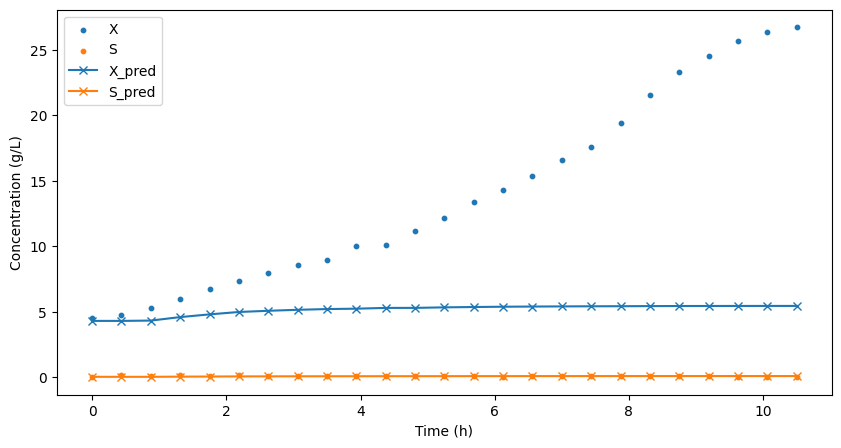

In [32]:
plt.figure(figsize=(10, 5))
plt.scatter(t_test, X_test, s=10, label="X")
plt.scatter(t_test, S_test, s=10, label="S")

plt.plot(t_test, X_preds, marker='x', label="X_pred")
plt.plot(t_test, S_preds, marker='x', label="S_pred")

plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()